<font size="5">ライブラリのインストール</font>

In [1]:
# !pip install jupyter-contrib-nbextensions
# !pip install jupyter-nbextensions-configurator

# !jupyter contrib nbextension install
# !jupyter nbextensions_configurator enable
# !pip install torchsummary

<font size="5">ライブラリのインポート

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

<font size="5">cpuとgpuの選択

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "gpu")

<font size="5">乱数を特定の値にして再現性を確保

In [4]:
# For reproducibility
torch.manual_seed(42)
if use_cuda:
    torch.cuda.manual_seed(42)

<font size ="5">pytorch用データセットの作成

In [5]:
# Load MNIST dataset
# pytorchではTensorというデータ構造で、モデルの入力、出力、パラメータを表現
# 前処理の定義
"""
これから取得するDatasetの中身がndarray型のデータ集合であるため、前処理でtensor型にしたい

root
Datasetを参照(または保存)するディレクトリを「path」の部分に指定する.
そのディレクトリに取得したいDatasetが存在すればダウンロードせずにそれを使用する.

train
Training用のdataを取得するかどうかを選択する.
FalseにすればTest用のdataを取得するが,この2つの違いはdata数の違いと思ってくれて良い.

download
rootで参照したディレクトリにDatasetがない場合ダウンロードするかどうかを決めることができる.

transform
定義した前処理を渡す.
こうすることでDataset内のdataを参照する時にその前処理を自動で行ってくれる.
"""
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 学習用データとテスト用データの取得
# transformは私用すると前処理を指定できる
# これによりdatasetをdetaloaderに渡して使える状態にした
train_dataset_original = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
print(f"Train Dataset Size: {len(train_dataset_original)}")
test_dataset_original = datasets.FashionMNIST(root='./data', train=False, transform=transform)
print(f"Test Dataset Size: {len(test_dataset_original)}")


Train Dataset Size: 60000
Test Dataset Size: 10000


C:\Users\y9723\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<font size ="5">Siamese Network用MNISTデータセットクラスの作成

In [6]:
# Siamese Network用MNISTデータセットクラスの作成
class SiameseMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset=dataset
        self.length=len(self.dataset)
        self.pair_index=[]     # Siamese Net用画像ペアインデックス配列
        labels=[label for _, label in self.dataset]     # 入力されたデータセットからラベル情報のみ抽出
        positive_count=0     # positiveペアのカウント
        negative_count=0     # negativeペアのカウント
        random_index=np.arange(self.length)     # ？？？
        
        while positive_count + negative_count < self.length:
            np.random.shuffle(random_index)
            for i in np.arange(self.length):
                if labels[i]==labels[random_index[i]]:     # 画像ペアのラベルが等しい時（positive）
                    if positive_count<self.length/2:      # おそらく比率を同じにしたい？？
                        self.pair_index.append([i, random_index[i], 1])      # 要素の構成：[<画像1のインデックス>,<画像2のインデックス>,<posi:1/nega:0フラグ>]
                        positive_count+=1
                    else:
                        continue
                else:
                    if negative_count<self.length/2:
                        self.pair_index.append([i, random_index[i], 0])
                        negative_count+=1
                    else:
                        continue
#         print("com", self.pair_index)
    def __len__(self):
        return self.length

    def __getitem__(self, index):

        return self.dataset[self.pair_index[index][0]][0], self.dataset[self.pair_index[index][1]][0], torch.tensor(self.pair_index[index][2])

<font size ="5">Siamese Network学習用Dataset, DataLoaderの作成

In [7]:
batch_size=64
train_dataset=SiameseMNIST(train_dataset_original) 
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_dataset_original, batch_size=1, shuffle=True)

In [8]:
train_dataset

<font size ="5">ペア画像の確認

torch.Size([1, 28, 28])
y[0]=0
y[1]=1
y[2]=1
y[3]=1
y[4]=1
y[5]=1
y[6]=0
y[7]=0
y[8]=0
y[9]=0


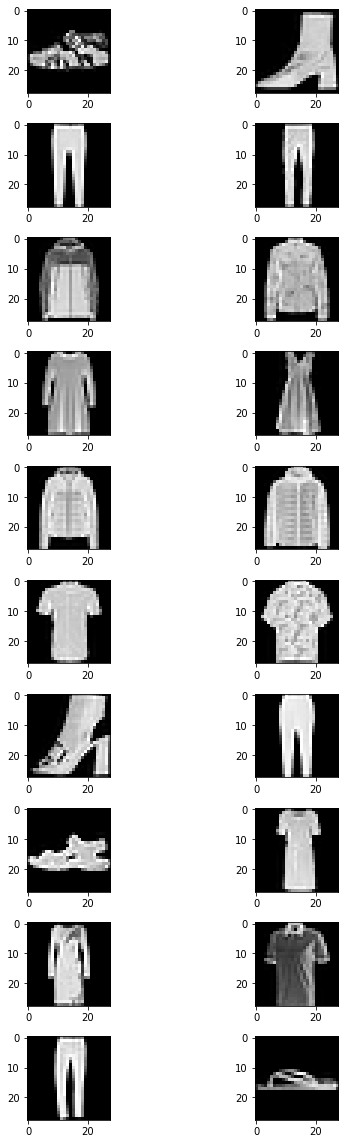

In [9]:
X1, X2, y = next(iter(train_loader))
print(X1[0].shape)
fig=plt.figure(tight_layout=True, figsize=(8, 16))
rows=10
for i in range(rows):
    print(f"y[{i}]={y[i]}")
    ax = fig.add_subplot(rows, 2, i*2+1)
    ax.imshow(X1[i][0].numpy(), cmap='gray')                          # X1[i].shape = (1, 28, 28)，X1[i][0].shape = (28, 28)
    ax = fig.add_subplot(rows, 2, i*2+2)
    ax.imshow(X2[i][0].numpy(), cmap='gray') 

<font size="5">モデルの構築

super()はあるクラス（子クラス）で別のクラス（親クラス）を継承できる。継承することで、親クラスのメソッドを子クラスから呼び出すことができる。
以下の形式
super().親クラスのメソッド

In [10]:
class BaseNetwork(nn.Module):
    """
    Base network for Siamese Network.
    This will be shared between two input images.
    """
    def __init__(self):
        super().__init__()

        # Define the layers
        # Using similar architecture as in the Keras example

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.act2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten and Dense Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Assuming input image size is 28x28
        self.act3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 256)
        self.act4 = nn.ReLU()

    def forward_1(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.maxpool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.dropout(x)
        x = self.fc2(x)
#         print("xのshape",x)
        x = self.act4(x)

        return x

    def forward(self, x1,x2):
        z1=self.forward_1(x1)
        z2=self.forward_1(x2)
        return z1,z2

# Test the base network with a sample input
base_network = BaseNetwork().to(device)
sample_input = torch.randn(8, 1, 28, 28).to(device)  # Batch of 8 images of sizammm28x28 with 1 channel
sample_output = base_network.forward_1(sample_input)

sample_output.shape  # Expected: [8, 256]


C:\Users\y9723\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([8, 256])

In [11]:
# # Siamse Networkモデルクラス
# class SiameseMnistModel(nn.Module):
    
#     def __init__(self):
#         super().__init__()
#         self.flatten = nn.Flatten()

#         self.encoder = nn.Sequential(
#             nn.Linear(28*28, 128),
#             nn.ReLU(),
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Linear(128, 32)
#         )
    
#     def forward_once(self, x):
#         x = self.flatten(x)
#         z = self.encoder(x)
#         return z
  
#     def forward(self, x1, x2):
#         z1 = self.forward_once(x1)
#         z2 = self.forward_once(x2)
#         return z1, z2

# Siamse Networkモデルクラス
import torch.nn as nn

class SiameseCNNMnistModel(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2), # 28x28x32
            nn.ReLU(),
            nn.MaxPool2d(2,2),                         # 14x14x32
            nn.Conv2d(32, 64, kernel_size=5, padding=2),# 14x14x64
            nn.ReLU(),
            nn.MaxPool2d(2,2)                          # 7x7x64
        )

        # Fully connected layers to get embeddings
        self.fc = nn.Sequential(
            nn.Linear(7*7*64, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )
    
    def forward_once(self, x):
        x = self.encoder(x)
        x = x.view(x.size()[0], -1)  # Flatten
        z = self.fc(x)
        return z
  
    def forward(self, x1, x2):
        z1 = self.forward_once(x1)
        z2 = self.forward_once(x2)
        return z1, z2


In [12]:
# class SiameseNetwork(nn.Module):
#     """
#     Siamese Network using the Base Network to compute embeddings.
#     Computes the Euclidean distance between the embeddings of two input images.
#     """
#     def __init__(self, base_network):
#         super().__init__()
#         self.base_network = base_network

#     def forward_one(self, x):
#         """
#         Forward pass for one input.
#         """
#         return self.base_network(x)

#     def forward(self, input1, input2):
#         """
#         Forward pass for both inputs.
#         """
#         output1 = self.forward_one(input1)
#         output2 = self.forward_one(input2)

#         # Compute Euclidean distance
#         dist = F.pairwise_distance(output1, output2, keepdim=True)

#         return dist

# # Test the Siamese network with sample inputs
# siamese_net = SiameseNetwork(base_network).to(device)
# sample_input1 = torch.randn(8, 1, 28, 28).to(device)
# sample_input2 = torch.randn(8, 1, 28, 28).to(device)
# sample_dist = siamese_net.forward(sample_input1, sample_input2)

# sample_dist.shape  # Expected: [8, 1]

<font size="5">損失関数

In [13]:
# class ContrastiveLoss(nn.Module):
#     """
#     Contrastive loss for Siamese Networks.
#     """
#     def __init__(self, margin=2.0):
#         super(ContrastiveLoss, self).__init__()
#         self.margin = margin

#     def forward(self, dist, label):
#         """
#         Compute contrastive loss.

#         Args:
#         - dist: Euclidean distance between the embeddings of two input images.
#         - label: 1 if the images are from the same class, 0 otherwise.
#         """
#         loss = (1/2) * label * torch.pow(dist, 2) + \
#                (1/2) * (1 - label) * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2)
#         return loss.mean()

# # Define the loss function and optimizer
# criterion = ContrastiveLoss().to(device)
# optimizer = optim.RMSprop(siamese_net.parameters(), lr=0.001)  # Using RMSprop as in the Keras example

# # Quick test of the loss function
# sample_label = torch.tensor([1, 0, 1, 0, 1, 0, 1, 0], dtype=torch.float32).to(device).unsqueeze(1)  # Simulating same and different classes
# loss_value = criterion(sample_dist, sample_label)
# loss_value.item()

# 損失関数
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, z1, z2, y):
        difference = z1 - z2
        distance_squared = torch.sum(torch.pow(difference, 2), 1)
        distance = torch.sqrt(distance_squared)       #平均：0.813，最大：1.663，最小：0.023，中央値：0.492
        negative_distance = self.margin - distance
        negative_distance = torch.clamp(negative_distance, min=0.0)
        loss = (abs(y+0.2) * distance_squared + (1 - (y-0.2)) * torch.pow(negative_distance, 2)) / 2.0
        loss = torch.sum(loss) / z1.size()[0]
        return loss

<font size ="5">学習の準備

In [14]:
import torch.optim as optim
from torchsummary import summary

#モデルのインスタンス化
model=SiameseCNNMnistModel().to(device)
print(model.parameters)
# ？？？？
summary(model, input_size=[(1, 28, 28), (1, 28, 28)])      # 入力が２つあるので（ペア画像だから）input_sizeはリストで複数指定する

# 最適化関数の定義
optimizer=optim.SGD(model.parameters(), lr=0.05)

# 損失関数のインスタンス化
criterion=ContrastiveLoss()

<bound method Module.parameters of SiameseCNNMnistModel(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3, bias=True)
  )
)>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
              

<font size ="5">学習の実行

epoch=0



nan/normal: 5/933
epoch=1



nan/normal: 5/933
epoch=2



nan/normal: 5/933
epoch=3



nan/normal: 5/933
epoch=4



nan/normal: 5/933
epoch=5



nan/normal: 5/933
epoch=6



nan/normal: 5/933
epoch=7



nan/normal: 5/933
epoch=8



nan/normal: 5/933
epoch=9



nan/normal: 5/933
epoch=10



nan/normal: 5/933
epoch=11



nan/normal: 5/933
epoch=12



nan/normal: 5/933
epoch=13



nan/normal: 5/933
epoch=14



nan/normal: 5/933
epoch=15



nan/normal: 5/933
epoch=16



nan/normal: 5/933
epoch=17



nan/normal: 5/933
epoch=18



nan/normal: 5/933
epoch=19



nan/normal: 5/933


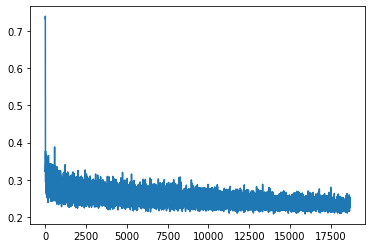

In [15]:
import copy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# モデル学習
repeat = 20                                                      # 学習回数
losses = []                                                       # 表示用損失値配列

model.train()                                                     # 学習モード
for epoch in range(repeat): 
  print(f"epoch={epoch}")
  nan_count = 0
  normal_count = 0

  # tqdmを使って学習の進行状況を表示
  for X1, X2, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{repeat}"):                                  
    # モデルによる特徴ベクトル算出
    output1, output2 = model(X1.to(device), X2.to(device))

    # 損失関数の計算
    loss = criterion(output1, output2, y.to(device))
#     print("com", y)

    # nan対策（lossにnanが含まれていれば１回前のモデルに戻す）
    if torch.isnan(loss):
      model = prev_model
      optimizer = optim.SGD(model.parameters(), lr=0.05)
      optimizer.load_state_dict(prev_optimizer.state_dict())
      nan_count += 1
      continue
    else:
      prev_model = copy.deepcopy(model)
      prev_optimizer = copy.deepcopy(optimizer)
      normal_count += 1

    # 表示用lossデータの記録
    losses.append(loss.item())

    # 勾配を初期化
    optimizer.zero_grad()
    
    # 損失関数の値から勾配を求め誤差逆伝播による学習実行
    loss.backward()
    
    # 学習結果に基づきパラメータを更新
    optimizer.step()

  print(f"nan/normal: {nan_count}/{normal_count}")
plt.plot(losses)                                                  # loss値の推移を表示


<font size ="5">モデルの出力ベクトルの取得

モデル学習の結果、同じクラスに属する画像の出力ベクトルは近くに、異なる数字に属する画像の出力ベクトルは遠くに配置されているはず。
これを確認するために、テストデータを用いて出力ベクトルを集める。
model.eval()で評価モードに設定し、変数の勾配も再計算されないようにtorch.no_grid()を記述する。

In [16]:
# モデル評価
model.eval()                                                      # 評価モード
with torch.no_grad():
    z_test = []
    y_test = []
    for X, y in test_loader:                                      # テスト用DataLoader
        z_test.append(model.forward_once(X.to(device)))           # テストデータをモデルに通して出力ベクトルを得る
        y_test.append(y)                                          # ラベル（靴、シャツ）の代わりにラベルIDとして0～9の数代わり振られている
    z_test = torch.cat(z_test, dim=0)                             # 多次元torch.tensor要素のリストをtorch.tensor化
    y_test = torch.tensor(y_test)                                 # スカラ要素(int)リストをtorch.tensor化

In [17]:
# 次元数の確認
print(z_test.size())
print(y_test.size())
# print(z_test_np)

torch.Size([10000, 3])
torch.Size([10000])


z_testとy_testをGPUに移動

In [18]:
# GPUが利用可能かチェック
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# z_testとy_testをGPUに移動
z_test = z_test.to(device)
y_test = y_test.to(device)
# ndarrayに変換
z_test_np = z_test.to('cpu').detach().numpy().copy()
y_test_np = y_test.to('cpu').detach().numpy().copy()
# print(z_test_np.shape)
# print(y_test_np.shape)

<font size="5">モデル出力ベクトルの分布可視化

①　そのまま可視化

<IPython.core.display.Javascript object>


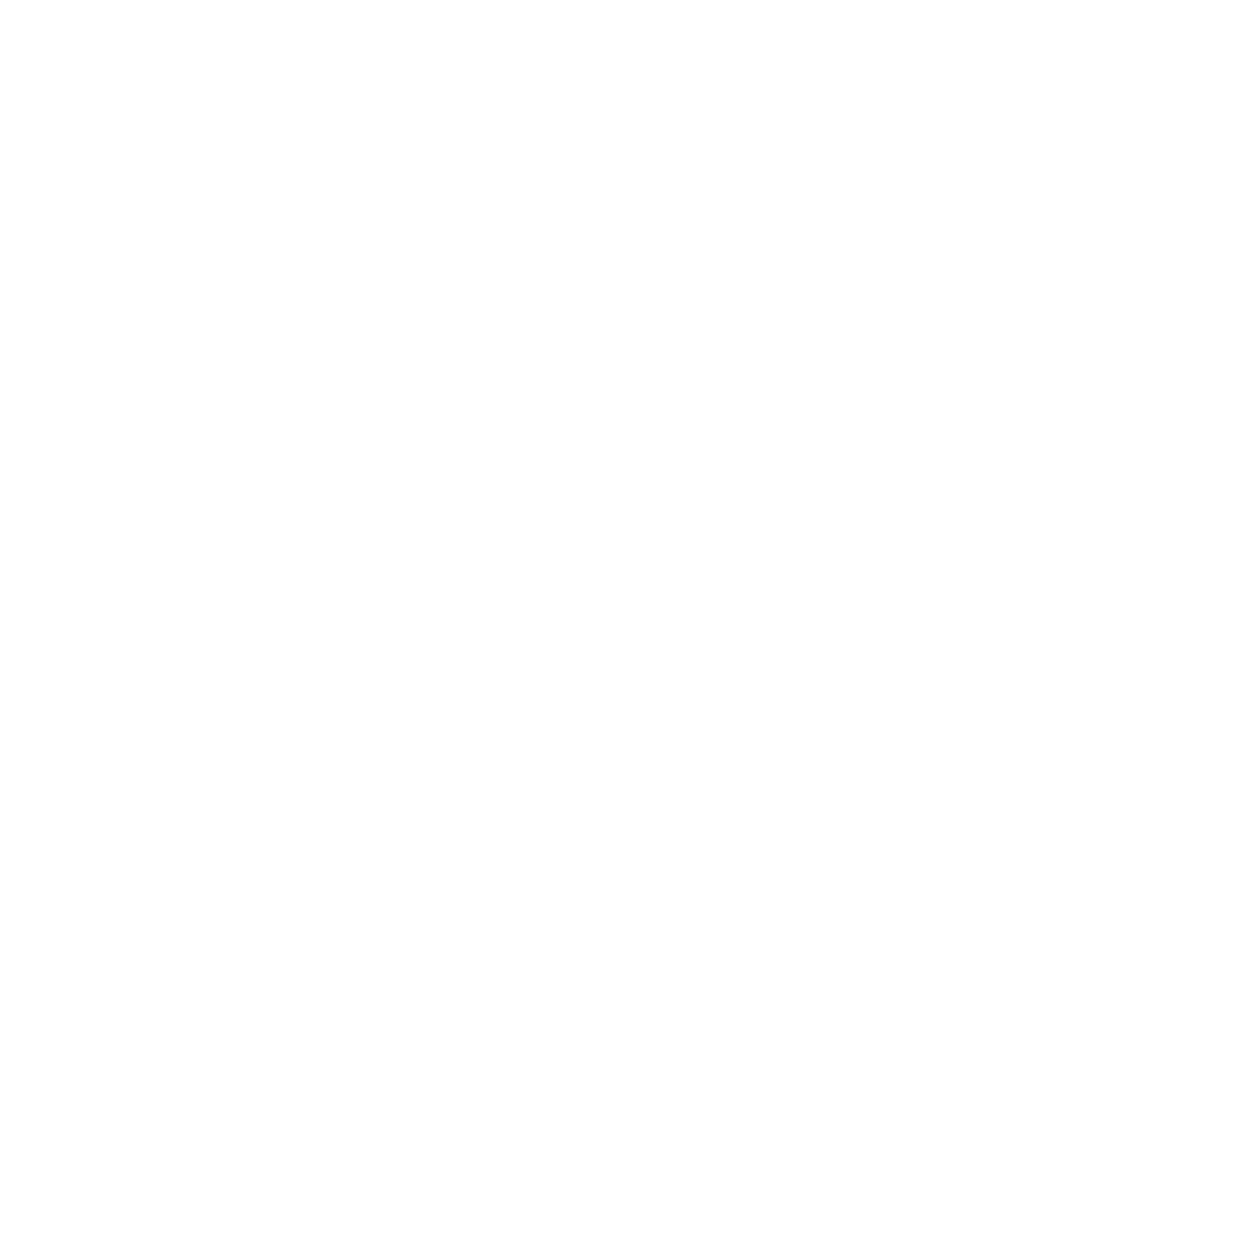

In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# クラス名
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# クラス数
class_num=len(class_names)
# 事前に定義された10色のリスト
colors = ["blue","green","red","cyan","magenta","yellow","black",'#f781bf','#a65628','#ff7f00']

# figureを生成する
plt.figure(figsize=(10, 10))
# axをfigureに設定する
ax = plt.subplot(111, projection='3d')
# クラスごとに色を分けてプロット
for i in range(class_num):
    ax.scatter(z_test_np[y_test_np==i, 0], z_test_np[y_test_np==i, 1], z_test_np[y_test_np==i, 2], color=colors[i], label=class_names[i])
ax.legend()  # 凡例の追加
plt.show()

②　重心を算出（ノイズクラスタリングなし）

In [20]:
# 重心を算出
def caluc_cluster(data, labels, i, class_num):
    x_1 = np.mean(data[labels==i, 0], axis=0)
    y_1 = np.mean(data[labels==i, 1], axis=0)
    z_1 = np.mean(data[labels==i, 2], axis=0)
    centroids=(x_1, y_1, z_1)
#     print("ラベル", i, "の重心：", x_1, y_1, z_1)
    return centroids

<IPython.core.display.Javascript object>


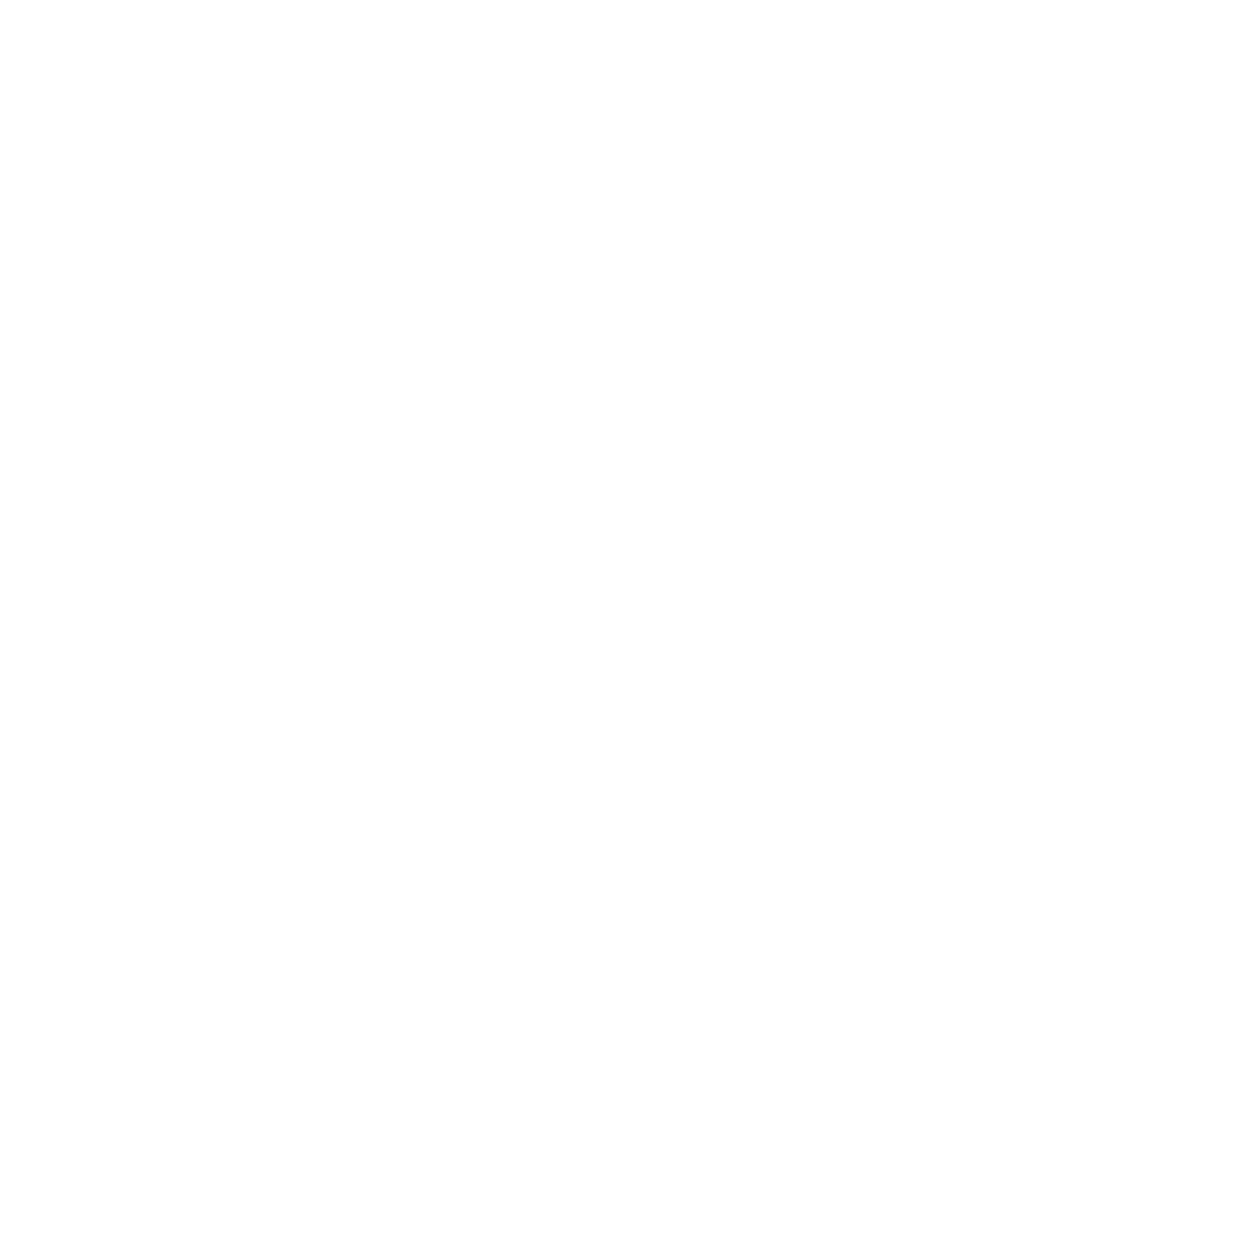

In [21]:
%matplotlib notebook

# 重心格納用のリスト
centroids=np.zeros((class_num, 3))

# figureを生成する
plt.figure(figsize=(10, 10))
# axをfigureに設定する
ax = plt.subplot(111, projection='3d')
# クラスごとに色を分けてプロット
for i in range(class_num):
    centroids[i]=caluc_cluster(z_test_np, y_test_np, i, class_num)
    ax.scatter(z_test_np[y_test_np==i, 0], z_test_np[y_test_np==i, 1], z_test_np[y_test_np==i, 2], color=colors[i], label=class_names[i], alpha=0.1)
    ax.scatter(centroids[i, 0], centroids[i, 1], centroids[i, 2], marker='*', color=colors[i], s=500, linewidths="4", edgecolors="black")
ax.legend()  # 凡例の追加
plt.show()

③　単位球面上に射影(目的クラスの重心を原点へ)

In [22]:
# 単位球面上に写像する関数
def norm(data):
    norm_data=data.copy()
    for i in range(len(data)):
        norm_data[i]=data[i] / np.linalg.norm(data[i], ord=2)
    return norm_data

<IPython.core.display.Javascript object>


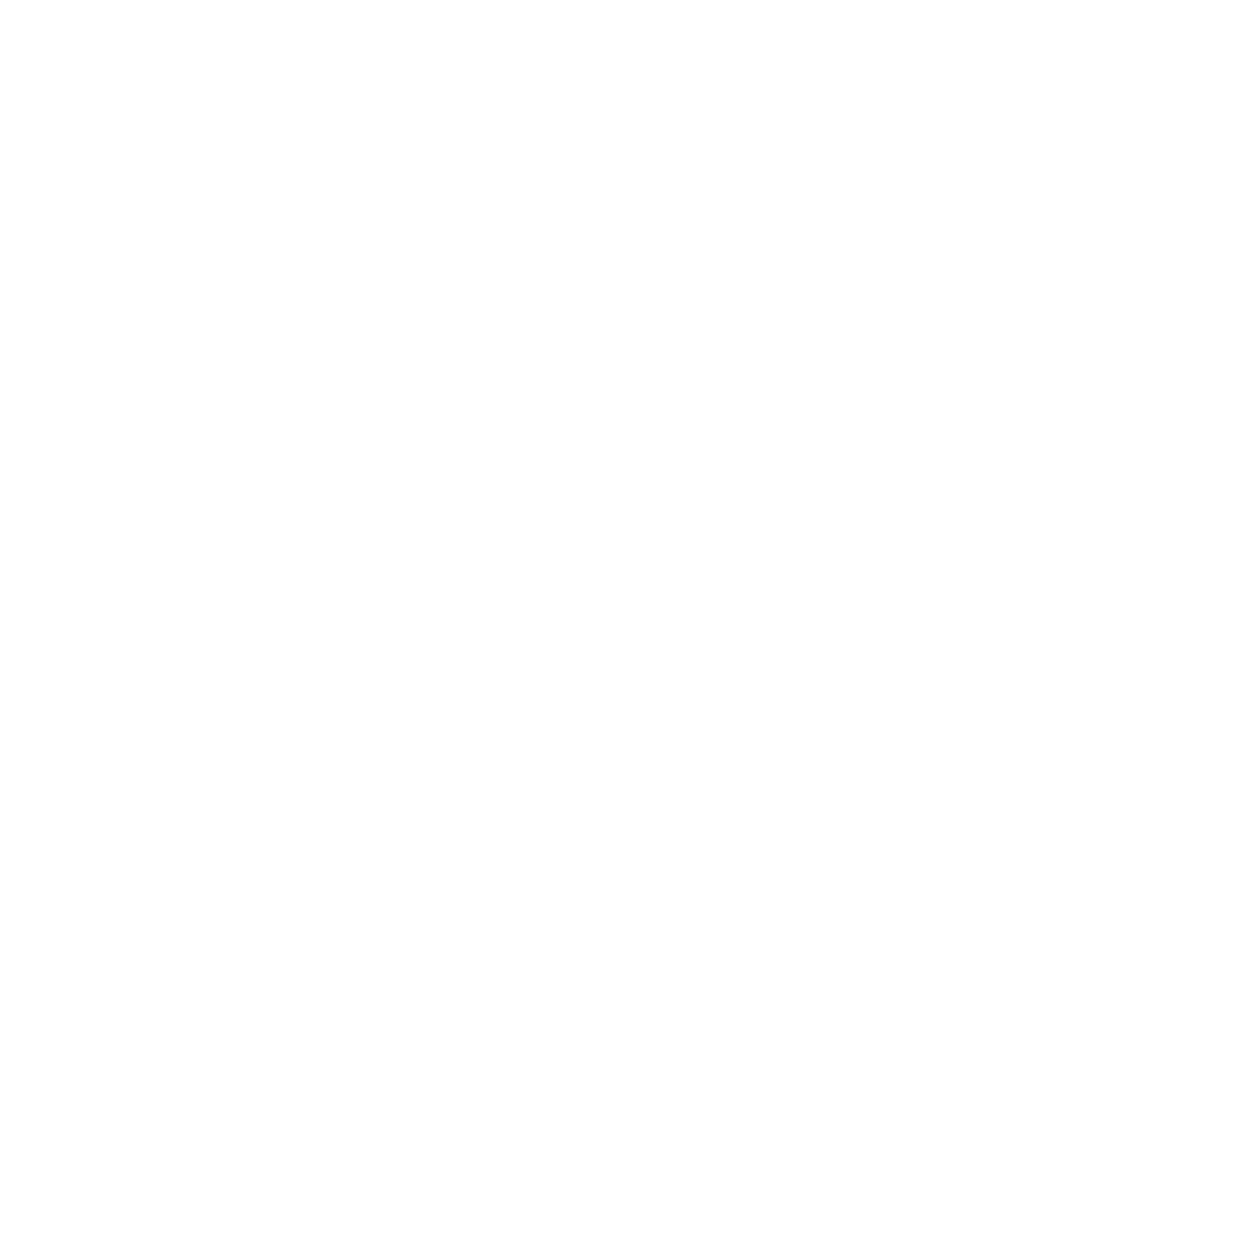

C:\Users\y9723\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
No handles with labels found to put in legend.


In [23]:
%matplotlib notebook

# 球体のパラメータ
radius = 1
phi = np.linspace(0, np.pi, 15)  # 緯度角の範囲
theta = np.linspace(0, 2 * np.pi, 30)  # 経度角の範囲
phi, theta=np.meshgrid(phi, theta)

# 球体の座標を計算
x = radius * np.sin(phi) * np.cos(theta)
y = radius * np.sin(phi) * np.sin(theta)
z = radius * np.cos(phi)


# 重心格納用のリスト
centroids=np.zeros((class_num, 3))

# figureを生成する
fig=plt.figure(figsize=(10, 10))
# axをfigureに設定する
ax = fig.add_subplot(111, projection='3d')
# 球体をプロット
ax.plot_surface(x, y, z, linewidth=1, edgecolor=(0.8, 0.8, 0.8, 1.0), alpha=0)


# クラスごとに色を分けてプロット
for i in range(class_num):
    centroids[i]=caluc_cluster(z_test_np, y_test_np, i, class_num)
    norm_data=norm(z_test_np)
    norm_centroids=norm(centroids)
#     print(norm_centroids[0,0].shape)
    ax.scatter(norm_centroids[i, 0], norm_centroids[i, 1], norm_centroids[i, 2], marker='*', color=colors[i], s=500, linewidths="1", edgecolors="black")
#     ax.scatter(norm_data[y_test_np==i, 0], norm_data[y_test_np==i, 1], norm_data[y_test_np==i, 2], color=colors[i], label=class_names[i], alpha=0.1)
ax.legend()  # 凡例の追加
plt.show()

<IPython.core.display.Javascript object>


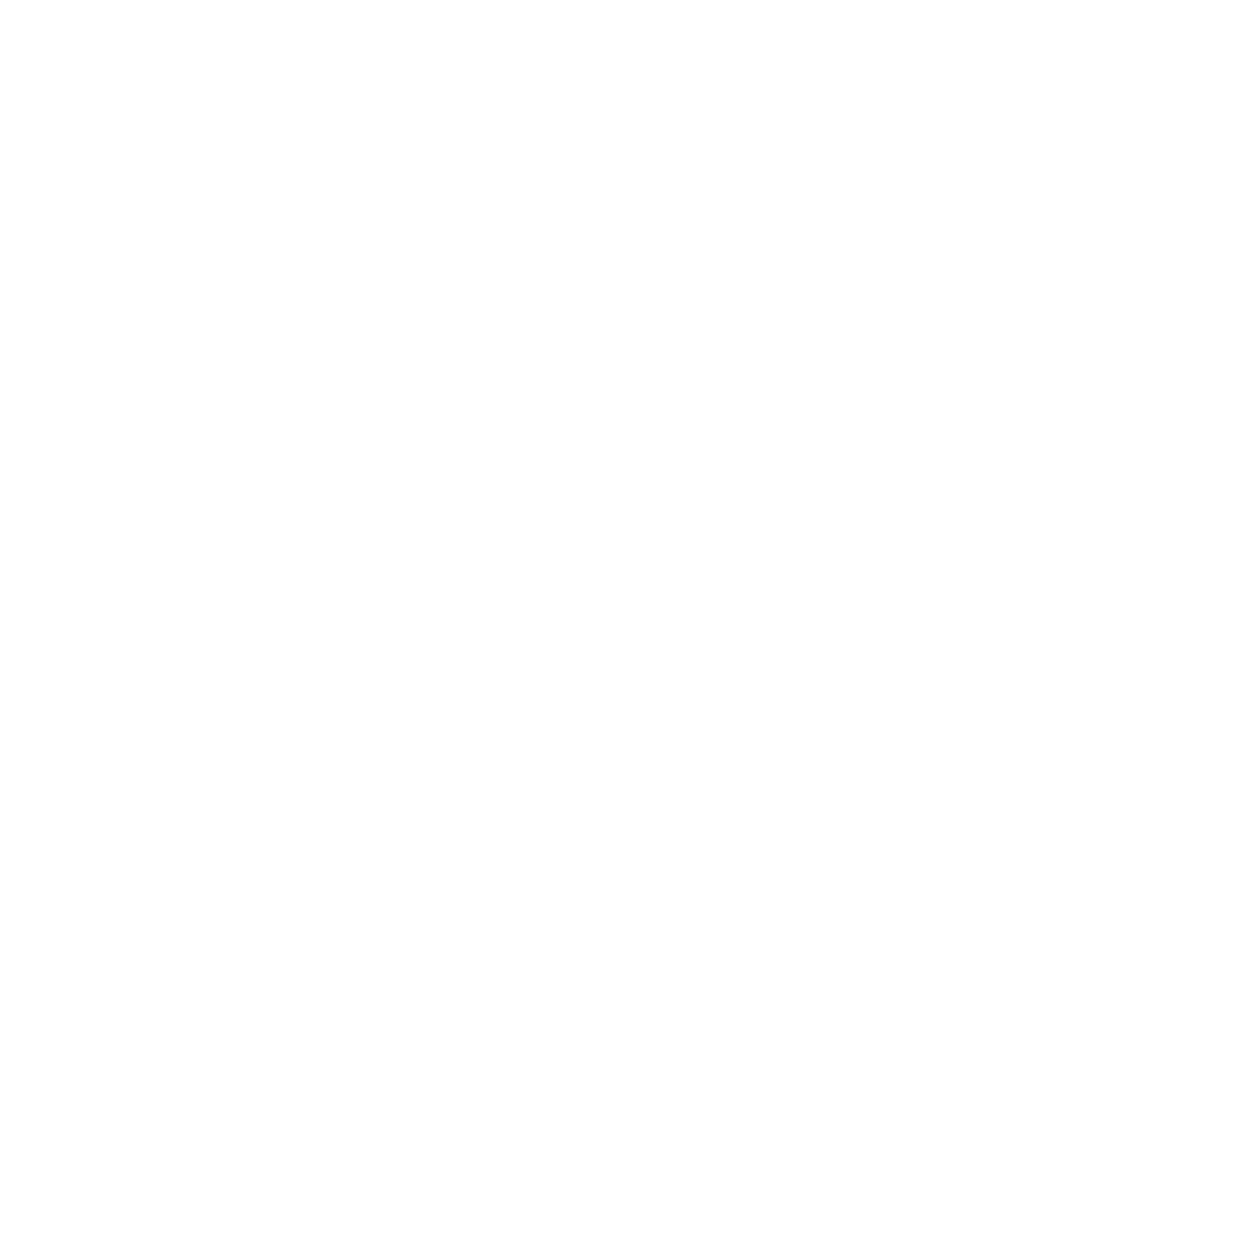

In [24]:
%matplotlib notebook

# 球体のパラメータ
radius = 1
phi = np.linspace(0, np.pi, 15)  # 緯度角の範囲
theta = np.linspace(0, 2 * np.pi, 30)  # 経度角の範囲
phi, theta=np.meshgrid(phi, theta)

# 球体の座標を計算
x = radius * np.sin(phi) * np.cos(theta)
y = radius * np.sin(phi) * np.sin(theta)
z = radius * np.cos(phi)


# figureを生成する
fig=plt.figure(figsize=(10, 10))
# axをfigureに設定する
ax = fig.add_subplot(111, projection='3d')
# 球体をプロット
ax.plot_surface(x, y, z, linewidth=1, edgecolor=(0.8, 0.8, 0.8, 1.0), alpha=0)


# クラスごとに色を分けてプロット
for i in range(class_num):
    centroids[i]=caluc_cluster(z_test_np, y_test_np, i, class_num)
    norm_data=norm(z_test_np)
    norm_centroids=norm(centroids)
#     ax.scatter(norm_centroids[i, 0], norm_centroids[i, 1], norm_centroids[i, 2], marker='*', color=colors[i], s=500, linewidths="1", edgecolors="black")
    ax.scatter(norm_data[y_test_np==i, 0], norm_data[y_test_np==i, 1], norm_data[y_test_np==i, 2], color=colors[i], label=class_names[i])
ax.legend()  # 凡例の追加
plt.show()

④　データの回転

In [25]:
import numpy as np
import math

def caluc_rotation_main(data):
    # 値の入力
    x=data[0, 0]
    y=data[0, 1]
    z=data[0, 2]
    
    # xの回転
    theta_1 = np.arctan2(y, z)
    
    x_rot_0 = x
    x_rot_1 = y*np.cos(theta_1) - z*np.sin(theta_1)
    x_rot_2 = y*np.sin(theta_1)+z*np.cos(theta_1)
    
    # 値の更新
    x=x_rot_0
    y=x_rot_1
    z=x_rot_2
    
    # yの回転
    theta_2 = np.arctan2(-x, z)
    
    y_rot_0 = x*np.cos(theta_2) + z*np.sin(theta_2)
    y_rot_1 = y
    y_rot_2 = -x*np.sin(theta_2) + z*np.cos(theta_2)
    
    ans=(y_rot_0, y_rot_1, y_rot_2)
    theta=theta_1, theta_2
    
    return ans, theta

def caluc_rotation_sub(data, theta):
    ans=np.zeros((9,3))
    for i in range(1,data.shape[0]):
        # 値の入力
        x=data[i, 0]
        y=data[i, 1]
        z=data[i, 2]

        # xの回転
        theta_1 = theta[0]

        x_rot_0 = x
        x_rot_1 = y*np.cos(theta_1) - z*np.sin(theta_1)
        x_rot_2 = y*np.sin(theta_1)+z*np.cos(theta_1)

        # 値の更新
        x=x_rot_0
        y=x_rot_1
        z=x_rot_2

        # yの回転
        theta_2 = theta[1]

        y_rot_0 = x*np.cos(theta_2) + z*np.sin(theta_2)
        y_rot_1 = y
        y_rot_2 = -x*np.sin(theta_2) + z*np.cos(theta_2)
        print(i)
        ans[i-1]=(y_rot_0, y_rot_1, y_rot_2)
    
    return ans

def caluc_rotation_data(data, theta):
    ans=np.zeros((data.shape[0],data.shape[1]))
#     print(ans.shape)
    for i in range(data.shape[1]):
        # 値の入力
        x=data[:, 0]
        y=data[:, 1]
        z=data[:, 2]

        # xの回転
        theta_1 = theta[0]

        x_rot_0 = x
        x_rot_1 = y*np.cos(theta_1) - z*np.sin(theta_1)
        x_rot_2 = y*np.sin(theta_1)+z*np.cos(theta_1)

        # 値の更新
        x=x_rot_0
        y=x_rot_1
        z=x_rot_2

        # yの回転
        theta_2 = theta[1]

        y_rot_0 = x*np.cos(theta_2) + z*np.sin(theta_2)
        y_rot_1 = y
        y_rot_2 = -x*np.sin(theta_2) + z*np.cos(theta_2)
        ans=(y_rot_0, y_rot_1, y_rot_2)
        
    
    return ans

# norm_centroids.shape[0]
ans, theta = caluc_rotation_main(norm_centroids)
print("回転行列 ans:")
print(ans)
print(theta)
ans_sub = caluc_rotation_sub(norm_centroids, theta)
print(ans_sub)
# ansを合体させる
ans_new=np.zeros((10, 3))
ans_new[0]=ans
ans_new[1:]=ans_sub
ans_new
new_data=caluc_rotation_data(norm_data, theta)
my_array = np.array(new_data, dtype=float)
my_array=np.transpose(my_array)
my_array.shape

回転行列 ans:
(0.0, -2.0816681711721685e-17, 1.0)
(-1.7144397353860876, 1.2066267062287284)
1
2
3
4
5
6
7
8
9
[[-9.99939699e-01  1.09803741e-02 -1.71065498e-04]
 [ 2.60410628e-02 -9.76573741e-01 -2.13601478e-01]
 [-7.42135395e-01 -4.90004449e-02  6.68456440e-01]
 [-4.89581858e-01 -8.64657618e-01 -1.12591335e-01]
 [-5.48780537e-01  7.91525176e-01  2.68938314e-01]
 [-1.45239674e-01 -7.98482446e-01  5.84235586e-01]
 [-5.30484922e-01  5.59704874e-01 -6.36644486e-01]
 [ 8.93473327e-01  2.12208253e-01 -3.95819492e-01]
 [-6.19921002e-01 -1.03663263e-01 -7.77786525e-01]]


(10000, 3)

<IPython.core.display.Javascript object>


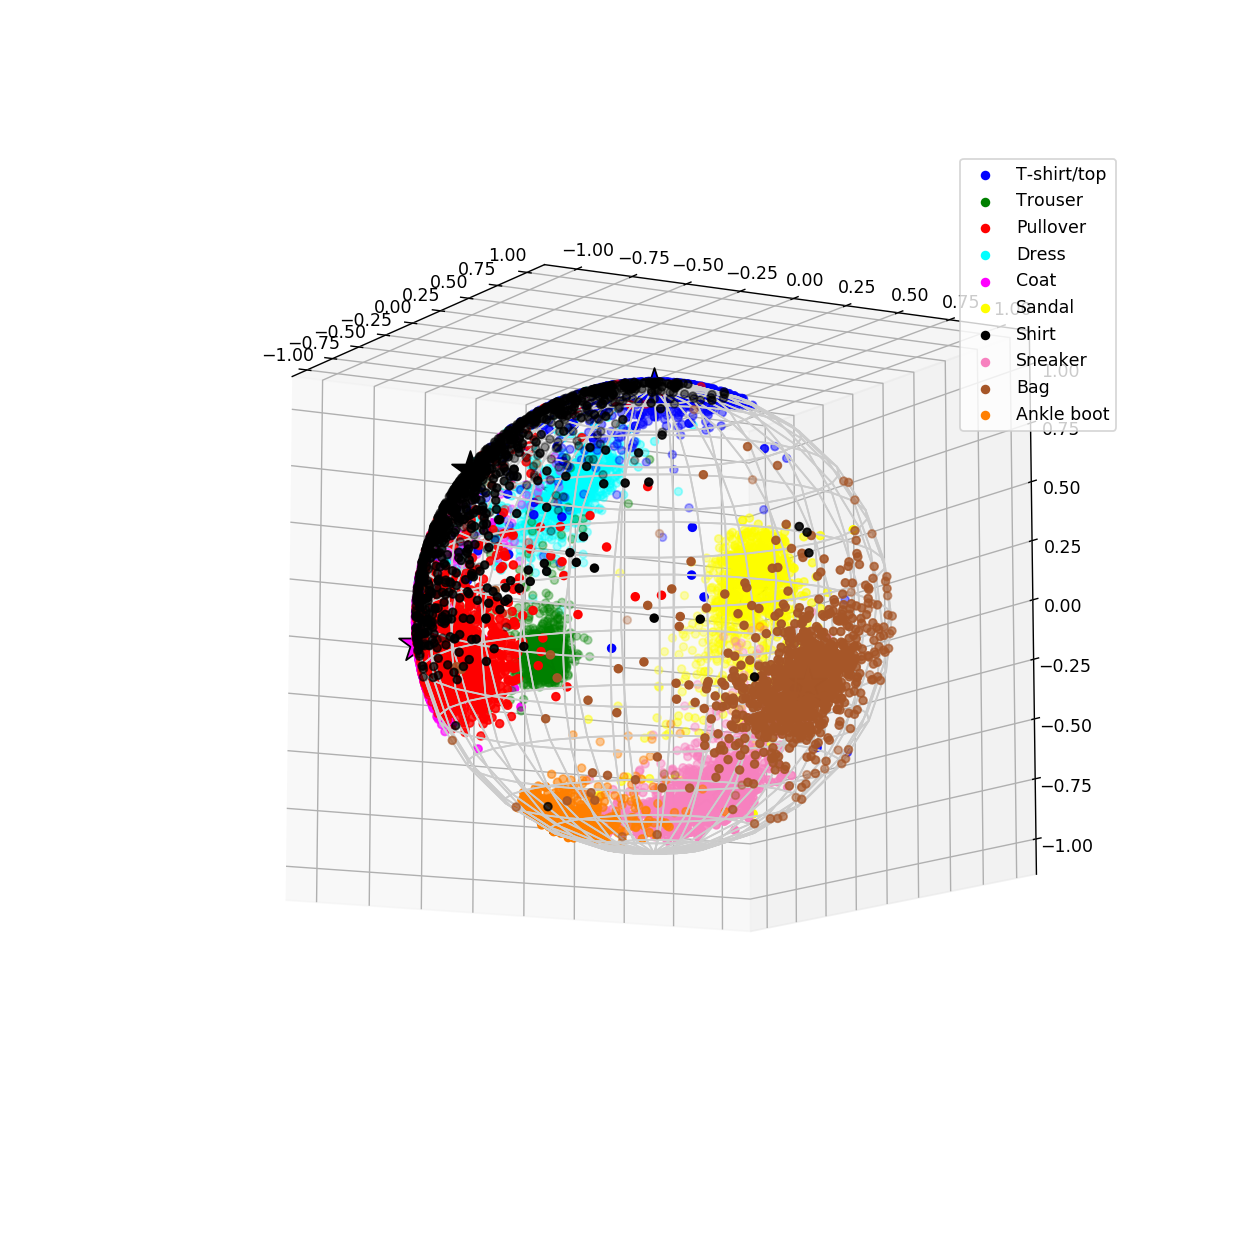

In [26]:
%matplotlib notebook

# 球体のパラメータ
radius = 1
phi = np.linspace(0, np.pi, 15)  # 緯度角の範囲
theta = np.linspace(0, 2 * np.pi, 30)  # 経度角の範囲
phi, theta=np.meshgrid(phi, theta)

# 球体の座標を計算
x = radius * np.sin(phi) * np.cos(theta)
y = radius * np.sin(phi) * np.sin(theta)
z = radius * np.cos(phi)


# figureを生成する
fig=plt.figure(figsize=(10, 10))
# axをfigureに設定する
ax = fig.add_subplot(111, projection='3d')
# 球体をプロット
ax.plot_surface(x, y, z, linewidth=1, edgecolor=(0.8, 0.8, 0.8, 1.0), alpha=0)


# クラスごとに色を分けてプロット
for i in range(class_num):
    centroids[i]=caluc_cluster(z_test_np, y_test_np, i, class_num)
    norm_data=norm(z_test_np)
    norm_centroids=norm(centroids)
#     ax.scatter(norm_centroids[i, 0], norm_centroids[i, 1], norm_centroids[i, 2], marker='*', color=colors[i], s=500, linewidths="1", edgecolors="black")
    ax.scatter(my_array[y_test_np==i, 0], my_array[y_test_np==i, 1], my_array[y_test_np==i, 2], color=colors[i], label=class_names[i])
    ax.scatter(ans_new[i, 0], ans_new[i, 1], ans_new[i, 2], marker='*', color=colors[i], s=500, linewidths="1", edgecolors="black")
#     ax.scatter(ans_sub[0], ans_sub[1], ans_sub[2], marker='*', color=colors[1], s=500, linewidths="1", edgecolors="black")
ax.legend()  # 凡例の追加
plt.show()

⑤　二次元空間にする

<IPython.core.display.Javascript object>


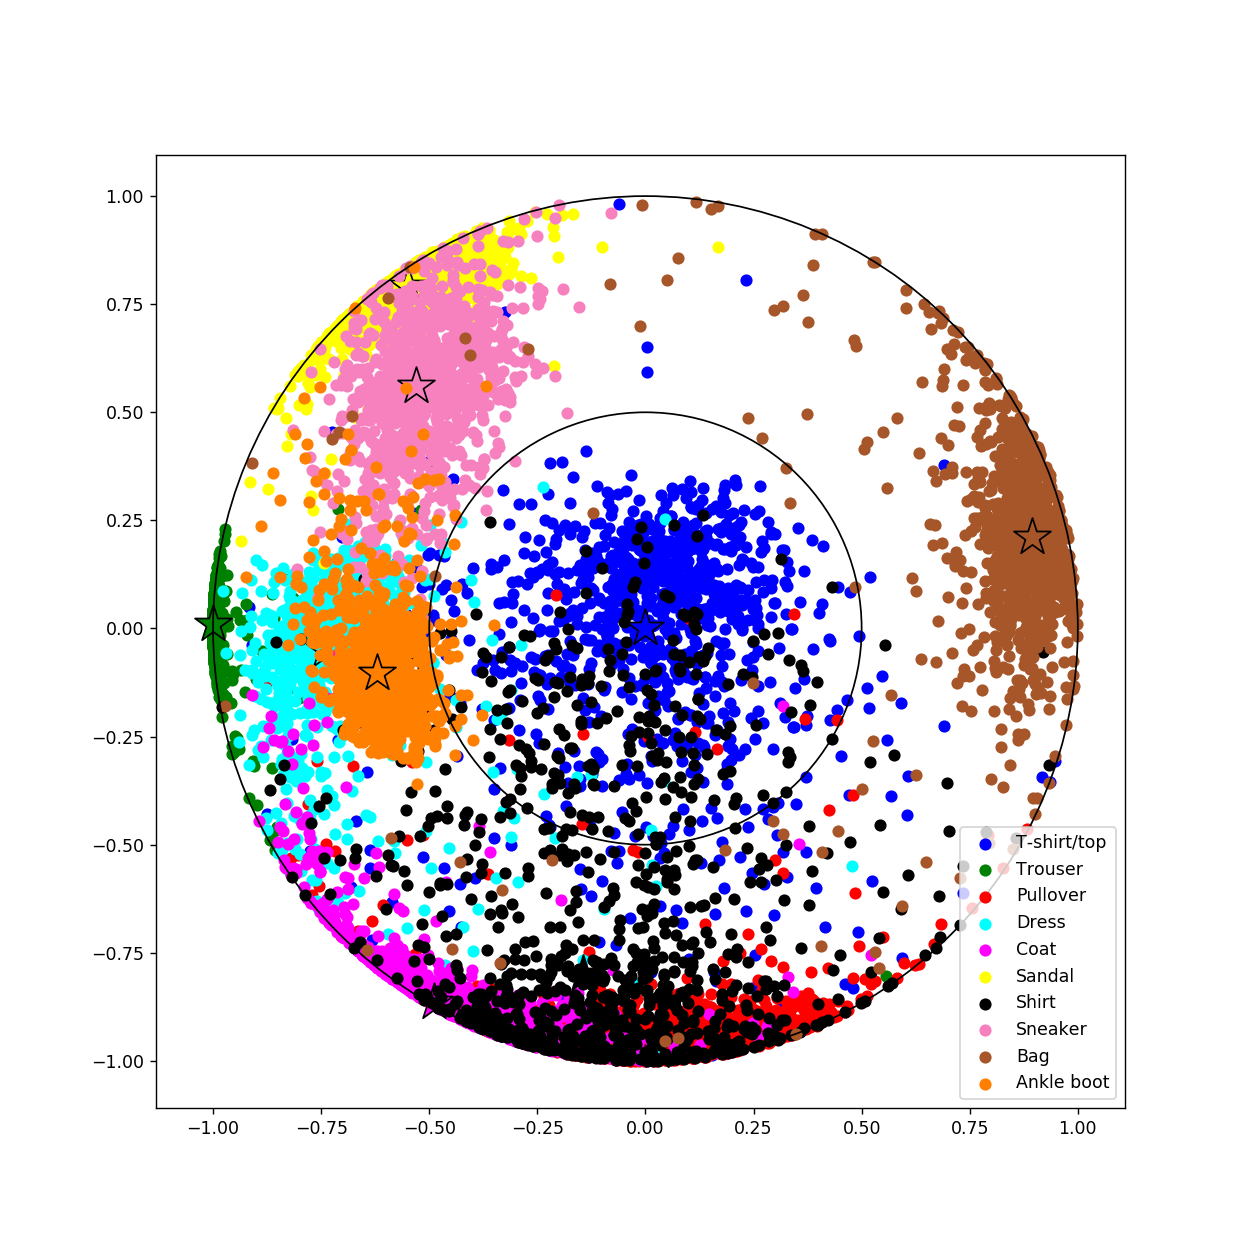

In [27]:
# %matplotlib notebook

# 球体のパラメータ
radius = 1
phi = np.linspace(0, np.pi, 15)  # 緯度角の範囲
theta = np.linspace(0, 2 * np.pi, 30)  # 経度角の範囲
phi, theta=np.meshgrid(phi, theta)

# 球体の座標を計算
x = radius * np.sin(phi) * np.cos(theta)
y = radius * np.sin(phi) * np.sin(theta)
z = radius * np.cos(phi)


# figureを生成する
fig=plt.figure(figsize=(10, 10))
# axをfigureに設定する
ax = fig.add_subplot()
draw_circle_05 = plt.Circle((0, 0), 0.5, fill=False)
draw_circle_1 = plt.Circle((0, 0), 1, fill=False)

ax.set_aspect(1)
ax.add_artist(draw_circle_05)
ax.add_artist(draw_circle_1)



# クラスごとに色を分けてプロット
for i in range(class_num):
    centroids[i]=caluc_cluster(z_test_np, y_test_np, i, class_num)
    norm_data=norm(z_test_np)
    norm_centroids=norm(centroids)
    ax.scatter(my_array[y_test_np==i, 0], my_array[y_test_np==i, 1], color=colors[i], label=class_names[i])
    ax.scatter(ans_new[i, 0], ans_new[i, 1], marker='*', color=colors[i], s=500, linewidths="1", edgecolors="black")
ax.legend()  # 凡例の追加
plt.show()

<IPython.core.display.Javascript object>


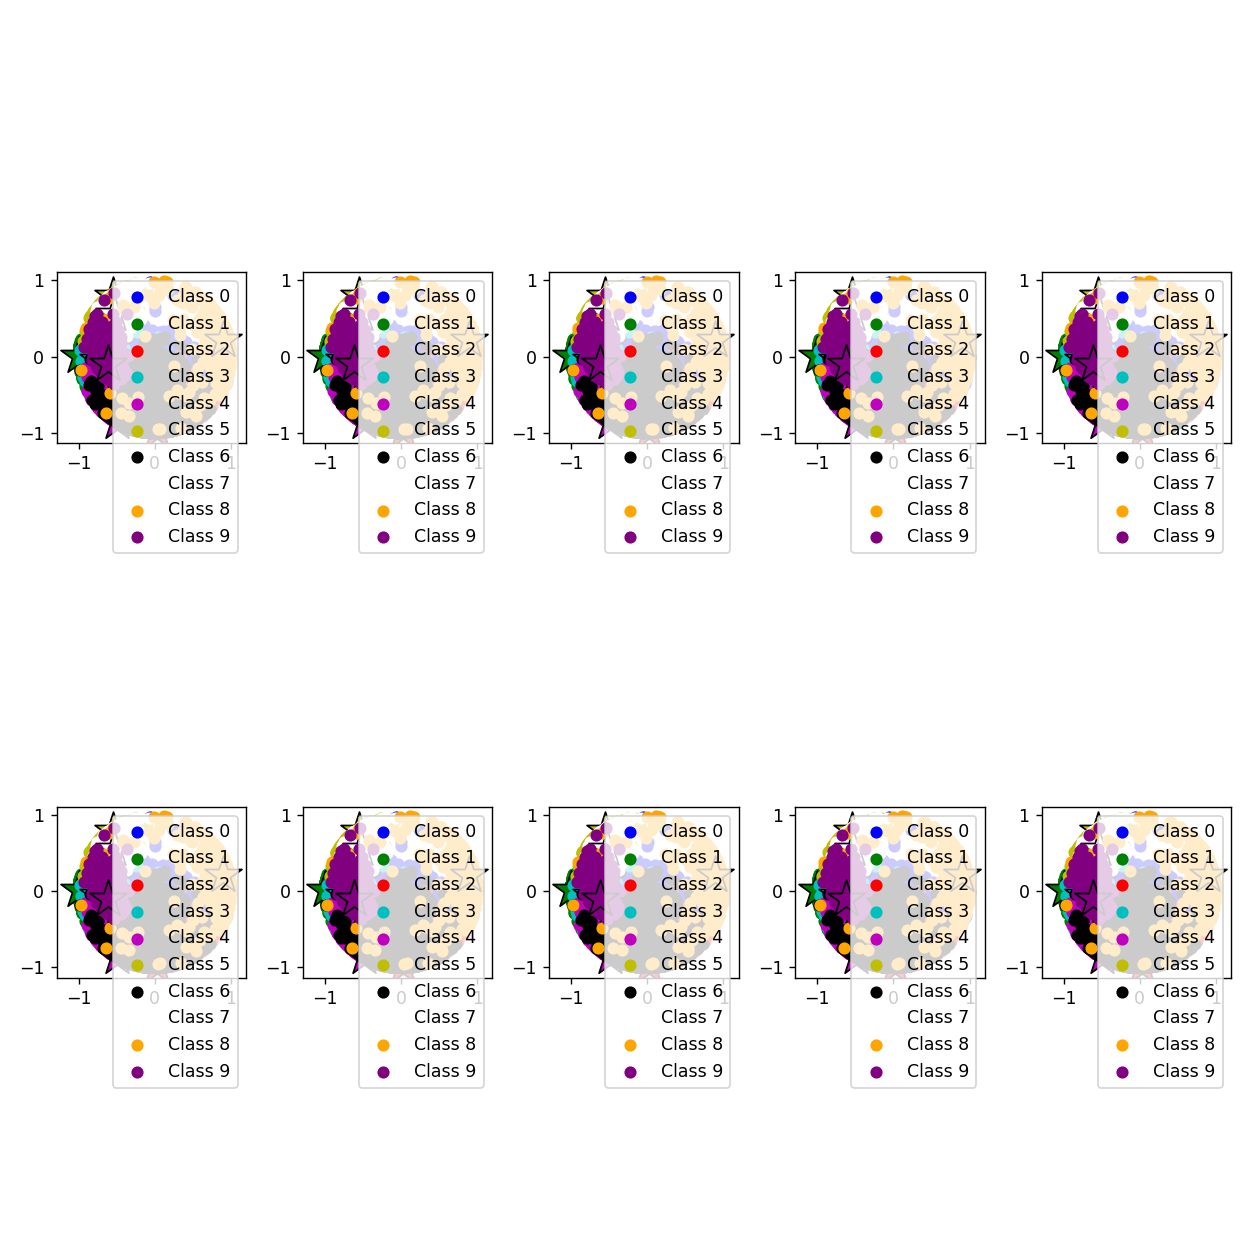

In [28]:
import matplotlib.pyplot as plt

# クラス数（class_num）を定義してください
class_num = 10

# クラスごとのデータ点を取得する関数 caluc_cluster の定義が必要です
def caluc_cluster(z_test, y_test, i, class_num):
    # ここに caluc_cluster 関数の実装を追加してください
    pass

# データの正規化関数 norm の定義が必要です
def norm(data):
    # ここに norm 関数の実装を追加してください
    pass

# データ点の座標を持つ my_array とクラスラベルを持つ y_test_np が必要です
# ans_new は星印でマークする中心点の座標を持つ必要があります

# クラスごとの色を定義
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']

# クラスごとの名前を定義
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']

# 2x5のサブプロットを持つfigureを生成して表示
fig, axes = plt.subplots(2, 5, figsize=(10, 10))

# 各サブプロットの縦横比を同じに設定
for ax in axes.ravel():
    ax.set_aspect('equal')

for ax in axes.ravel():
    # クラスごとに色を分けてプロット
    for i in range(class_num):
        centroids[i] = caluc_cluster(z_test_np, y_test_np, i, class_num)
        norm_data = norm(z_test_np)
        norm_centroids = norm(centroids)
        ax.scatter(my_array[y_test_np == i, 0], my_array[y_test_np == i, 1], color=colors[i], label=class_names[i])
        ax.scatter(ans_new[i, 0], ans_new[i, 1], marker='*', color=colors[i], s=500, linewidths="1", edgecolors="black")
    ax.legend()  # 凡例の追加

plt.tight_layout()  # グラフが重ならないように調整
plt.show()
